<div style="text-align: center; background-color: #559cff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
  FINAL PROJECT – Introduction to Data Science
</div>

<div style="text-align: center; background-color: #b1d1ff; font-family: 'Trebuchet MS', Arial, sans-serif; color: white; padding: 20px; font-size: 40px; font-weight: bold; border-radius: 0 0 0 0; box-shadow: 0px 6px 8px rgba(0, 0, 0, 0.2);">
    Exploratory data analysis
</div>

## Import

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import geopandas
%matplotlib inline

import seaborn as sns

## Exploring data

Read cleaned data from file

In [2]:
df = pd.read_csv("./data/final_data.csv")
df.shape

(3491, 37)

### Making questions

#### On numeric data

In [3]:
numeric_df = df.select_dtypes(include='number')
numeric_df.shape

(3491, 26)

**Question 1:** What is the correlation between numeric features in the dataset?

**Answering this question will** help us to have a general view about this dataset, identify and analyse the relationships between features and then determine which features within the dataset significantly contribute to our solution goal.

**How we answer this question**: create a correlation matrix, then visualize the matrix using heat map.

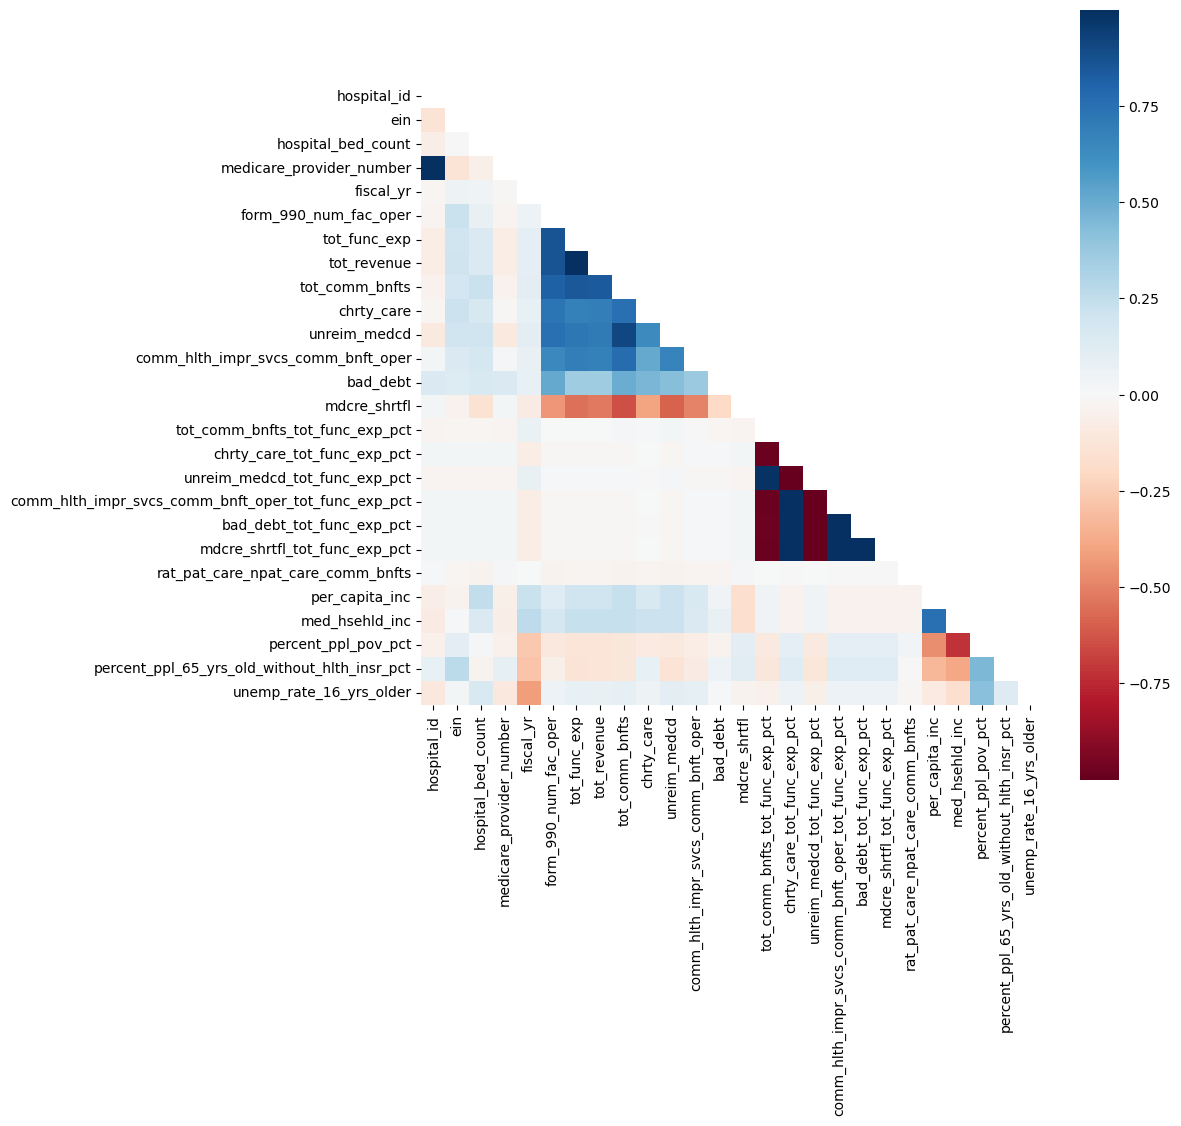

In [4]:
# create a copy
df_copy = df.copy()
corr = df_copy.corr()
matrix = np.triu(corr)
# plot a correlation matrix
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corr, cmap='RdBu', center=0,ax=ax, square=True, mask=matrix)
plt.show()

**Answer:** There are 3 regions that their features has significant influence to each other. They are (listed from High to Low, from Left to Right): 
- The 1st region create a group representing financial records of each hospital. Most of them have positive correlation except the `mdcre_shrtfl`.
- The 2nd region represent various percentages calculated in relation to the total functional expenses within an organization's financial records or reporting, possibly derived from Form 990 or financial statements. This group of featuers has strong correlations.
- The 3rd represent socio-economic indicators that are often used to assess and analyze the economic well-being and health status of a population within a specific area or region around each hospital.
- Other regions has small correlation ratios, therefore, their relation are not significant. 

**Question 2:** Do hospitals that are members of the Council of Teaching Hospitals differ in their provision of community benefits compared to non-members?

**Answering this question will** 

**How we answer this question**: 

**Question 3:** How do hospitals in each state in USA allocate funds for community benefits?

**Answering this question will** indicate how hospital in USA contribute to community around their area.

**How we answer this question**: extract average money each state uses for community benefit, charity care, and community improvement services, then visualize them to see how diffence. We can not draw all hospital so we will only choose top 5 highest and lowest average functional expenses for visualization.

### Analyzing to get the answer

       Other Services  Charity Care  Comm Heath Improvement
state                                                      
HI           7.186540      2.366417                0.214763
UT           6.920114      2.391912                0.203217
CA           7.862008      1.226529                0.377566
NV          13.627532      1.010646                0.742600
WY           6.231016      2.342237                0.199628
       Other Services  Charity Care  Comm Heath Improvement
state                                                      
AR          15.227179      2.001829                0.087434
OK           4.728029      1.910916                0.070891
AL          11.075229      7.554251                0.598964
KS           6.720272      1.496690                0.162010
MT           6.868983      0.817555                0.340790


<Axes: title={'center': '5 Lowest Expenses'}, xlabel='State', ylabel='%'>

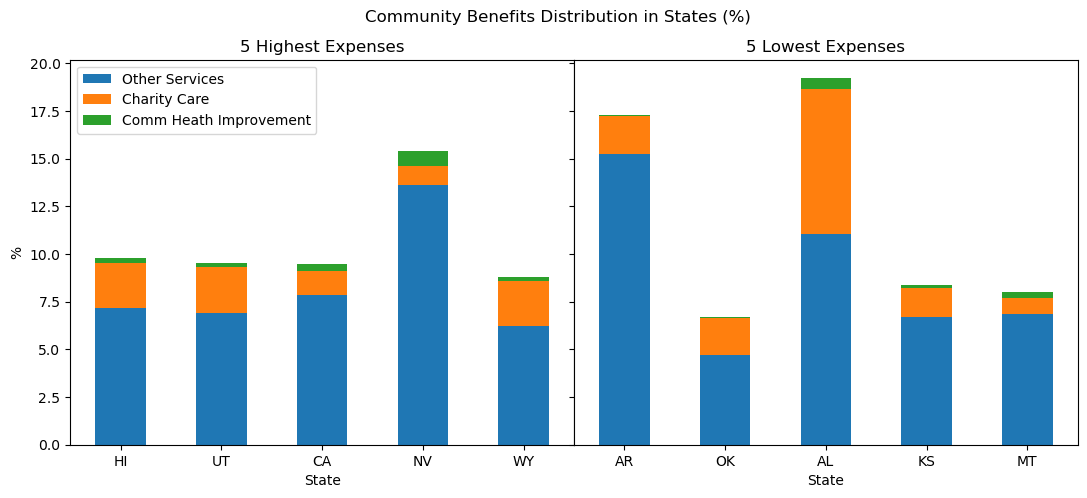

In [169]:
state_df = pd.DataFrame()
state_df['avg_func_exp'] = df.groupby('state')['tot_func_exp'].mean()
# state_df['avg_comm_bnfts'] = df.groupby('state')['tot_comm_bnfts_tot_func_exp_pct'].mean()
state_df['Charity Care'] = df.groupby('state')['chrty_care_tot_func_exp_pct'].mean()
state_df['Comm Heath Improvement'] = df.groupby('state')['comm_hlth_impr_svcs_comm_bnft_oper_tot_func_exp_pct'].mean()
state_df['Other Services'] = df.groupby('state')['tot_comm_bnfts_tot_func_exp_pct'].mean() - state_df['Charity Care'] - state_df['Comm Heath Improvement']
state_df.sort_values('avg_func_exp', inplace=True, ascending=False)

temp = state_df[['Other Services', 'Charity Care', 'Comm Heath Improvement']]

high_func_exp_states = temp.head().index
low_func_exp_states = temp.tail().index

high_exp_df = temp.loc[high_func_exp_states, :]
low_exp_df = temp.loc[low_func_exp_states, :]
print(high_exp_df)
print(low_exp_df)

fig, ax = plt.subplots(1, 2, figsize = (13, 5), sharey=True)
plt.subplots_adjust(wspace=0)
plt.suptitle('Community Benefits Distribution in States (%)')
high_exp_df.plot(kind='bar', ax=ax[0], xlabel='State', ylabel='%', stacked=True, title='5 Highest Expenses', rot=0).legend(loc='upper left',)
low_exp_df.plot(kind='bar', ax=ax[1], xlabel='State', ylabel='%', stacked=True, title='5 Lowest Expenses', rot=0, legend=None)

**Answer :** In state of the top 10 highest-expense states, nearly 10% of their total functional expenses are allocated towards community benefits. Among these, charity care typically represents a higher percentage compared to community health improvement activities. Conversely, in the 10 lowest-expense states, despite lower total functional expenses, a significant focus remains on community benefits. Notably, Alabama dedicates nearly 20% of its total expenses to community benefits, surpassing the highest percentage observed among the top 10 highest-expense states (16%).

**Question 4:** The number of hospitals prioritizing patient-centric care (treatment and direct patient support) versus non-patient-oriented hospitals their activities aimed at the general community's health and well-being, in both urban and rural area.

**Answering this question will** reveal the types of hospitals prevalent in various regions across the USA.

**How we answer this question**: add a new column to label each hospital kind as patient or non-patient based on Ratio of Patient Care to Non-patient Care Community Benefits. Count number of each kind in each area of USA: urban or rural.

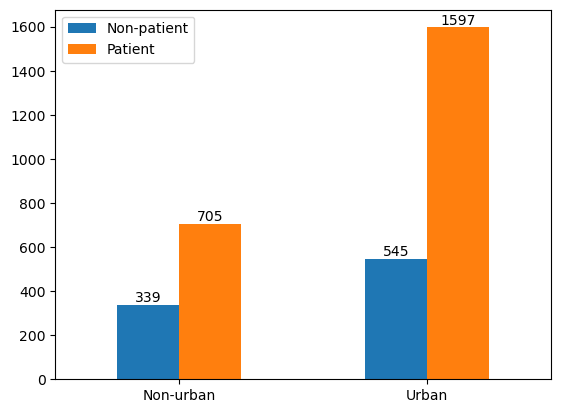

In [207]:
# pre-processing
temp = df[df['rat_pat_care_npat_care_comm_bnfts'] > 0]

# create array to store new columns: rat_pat_care_npat_care_comm_bnfts < 1 -> 'non-patient' else 'patient'
hos_type = np.full((temp.shape[0],), 'patient', dtype=object)
hos_type[temp['rat_pat_care_npat_care_comm_bnfts'] < 1] = 'non-patient'

# attach new columns to df
temp['type'] = hos_type

# count number of hospital in each type in urban and non-urban area
temp = temp.groupby(['urban_location_f','type'])['hospital_id'].count()
temp = temp.to_numpy().reshape(2, 2)

hos_type_df = pd.DataFrame(temp, index=['Non-urban', 'Urban'], columns=['Non-patient','Patient'])

ax = hos_type_df.plot(kind='bar', rot=0)
for container in ax.containers:
    ax.bar_label(container)

**Answer:** Both urban and non-urban area have number of patient-oriented hospital more than non-patient-oriented. However, in non-urban area, the non-patient one take account of nearly 1/3 of the total number of hospital, while in urban area, this ratio is only 1/4.

**Question :**

**Answering this question will** 

**How we answer this question**: 

**Question :**

**Answering this question will** 

**How we answer this question**: 